# Group project (Master)

Analysis of competitiveness of different energy production technologies in Danish Electricity Market

## Modeling of current energy system

### Data gathering and analysis

Latest energy statistics reports available is for 2018. Thereforte, all data used is dated to year 2018.

Hourly consumption, production, as well as wind energy production data available from https://www.nordpoolgroup.com/historical-market-data/

In [5]:
using CSV, VegaLite, DataFrames, Statistics

consum = CSV.read("consumption-dk-areas_2018_hourlys.csv", DataFrame)
produc = CSV.read("production-dk-areas_2018_hourly.csv", DataFrame)
wind   = CSV.read("wind-power-dk_2018_hourlys.csv", DataFrame)
exp    = CSV.read("exchange-per-country_2018_hourly.csv", DataFrame)
solar  = CSV.read("solarpv2018.csv", DataFrame)


n = 300

#production with wind substracted
#dif = produc[1:n,"DK"]-wind[1:n,"DK"]

#data = vcat(DataFrame(time_hr=collect(1:n),power_MWh = consum[1:n,"DK"]*1000, tp = "Consumption",source = 2),           
#            DataFrame(time_hr=collect(1:n),power_MWh = dif*1000, tp ="Production",source = 1),
#            DataFrame(time_hr=collect(1:n),power_MWh = wind[1:n,"DK"]*1000, tp = "Wind",source = 1),
#            DataFrame(time_hr=collect(1:n),power_MWh = exp[1:n,"DK"]*1000, tp = "Import",source = 1))

#Plotting data
#data |>
#@vlplot(width=850, hieght=700)+
#@vlplot(mark=:area, x=:time_hr, y={:power_MWh,stack=:zero},color=:tp,transform=[{filter="datum.source==1"}]) +
#@vlplot(mark=:line, x=:time_hr, y=:power_MWh, transform=[{filter="datum.source==2"}],
#    color={:tp,
#    scale={range = ["red","#a1d99b","#fd8d3c","#3182bd"]}})

300

### Modeling
Energy system could be modeled based on the data from above. In this case the system would consist of already deployed units and investment opportunities what will further optimize the system (Minimize costs). Wind production will be substracted from consumption for each of the time steps and optimization for mix of technologies covering the difference will be made.

Additional information required:
+ Operational prices for existing power plants based on type of plant/fuel
+ Investment prices (price per KW) for further investments 


In [6]:
p = 1000    #to convert to EU per MWh
inp = DataFrame(Name            = ["Solar PV","Wind Onshore","Wind Offshore","Biogas","Brown coal","Hard coal","CCGT","GT"],
                Capex_avg       = [700,1750,3900,3000,1900,1650,950,500]*p,    #investment cost EUR/kW (nominal capacity)
                Lifetime        = [25,25,25,30,40,40,30,30],                   #Years
                Opex_of_capex   = [0.025,0,0,0.04,0,0,0,0],                    #EUR/kw % of CAPEX
                Opex_fix        = [0,30,100,0,36,32,22,20]*p,                  #EUR/Kw
                Opex_var        = [0,0.005,0.005,0,0.005,0.005,0.004,0.003]*p, #EUR/kwh
                Fuel_price      = [0,0,0,30.3,1.8,9.6,21,21],                  #EUR/MWh heat
                Fuel_eff        = [1,1,1,0.4,0.45,0.46,0.6,0.6])               #el. eng. % of heat en

,Name,Capex_avg,Lifetime,Opex_of_capex,Opex_fix,Opex_var,Fuel_price
,String,Int64,Int64,Float64,Int64,Float64,Float64
1,Solar PV,700000,25,0.025,0,0.0,0.0
2,Wind Onshore,1750000,25,0.0,30000,5.0,0.0
3,Wind Offshore,3900000,25,0.0,100000,5.0,0.0
4,Biogas,3000000,30,0.04,0,0.0,30.3
5,Brown coal,1900000,40,0.0,36000,5.0,1.8
6,Hard coal,1650000,40,0.0,32000,5.0,9.6
7,CCGT,950000,30,0.0,22000,4.0,21.0
8,GT,500000,30,0.0,20000,3.0,21.0


### Estiamtion of the capacity factor

In [7]:
T = size(consum)[1]
#capacity factor
c = []
append!(c, wind[i,"DK"]/maximum(wind[1:T,"DK"]) for i=1:T)    #capacity factor
println("")

### Mathematical  formualtion

**Variables:** 
<br> $p_{it}$ production of technology i in time unit t
<br> $p_i^{max}$ max power production of unit i

**Parameters:**
<br> $a$ - operations varaible cost [EUR/KWh]
<br> $f$ - fuel price [EUR/KWh]
<br> $e$ - fuel efficiency []
<br> $b$ - CAPEX [EUR/KWh]
<br> $l$ - expected system lifetime [yr.]
<br> $o$ - fixed operational expenses [EUR/kw % of CAPEX]
<br> $k$ - fixed operational expenses [EUR/kw]
<br> $d$ - demand for power [Mw]
<br> $c$ - capacity factor 

**Objective:** 
<br>to minimize cost of electricity

$$Z = \dfrac{\sum_{t=1}^{T}\sum_{i=1}^{n}p_{it} \left( a_i+ f_ie_i\right) + 
\sum_{i=1}^{n} \dfrac{p^{max}_{i}}{l_{i}}\left(b_i(1+o_i)+k_{i} \right)}{\sum_{t=1}^{T}d_t} \tag{1}$$

$$p_{it}\leq p^{max}_i \tag{2} $$

$$p_{wt} = p^{max}_w c_{wt} \tag{3} $$

$$p^{max}_i \leq \sum_{t=1}^{T} d_t \tag{4} $$

$$\sum_{i=1}^{I} p_{it} \geq d_t \tag{5} $$

$$\sum_{i=4}^{8} p_{it} \geq d_t \tag{5} * r_s $$

$$p_{it},p_{i}^{max} \geq 0 $$

### Renewable deployment strategy

Most of the active wind turbines in Denmark were onshore, around 5.7 thousand compared to 558 offshore.

In [8]:
max_wind = 5700 * 5     #max number of onshore turbines

28500

## Mathematical model

In [141]:
using CSV, JuMP, GLPK, CPLEX

#Declaration of data frames

function optimize(x,y,fp,d)
println("entree opti")
#fp = share for change in fuel prices
#d  =  share for change in demand
    
n = size(inp)[2]
T = y
M = 10*maximum(consum[1:T,"DK"])

m = Model(GLPK.Optimizer)

@variable(m,p[i=1:n,t=1:T] >= 0)        #power per technology
@variable(m,pmax[i=1:n] >= 0)           #power per technology
@variable(m,u[i=1:n], Bin)         #controling number of technologies

@objective(m, Min, (sum(p[i,t]*                      (inp[i,"Opex_var"] + inp[i,"Fuel_price"]*(1+fp)*inp[i,"Fuel_eff"])            for i=1:n for t=1:T) +
                    sum((pmax[i]/inp[i,"Lifetime"])* (inp[i,"Capex_avg"]*(1+inp[i,"Opex_of_capex"])+inp[i,"Opex_fix"])      for i=1:n))/
                    sum(consum[t,"DK"]                                                                                  for t=1:T)*(1+d)  )

@constraint(m, Solar[t=1:T],                 p[1,t] <= pmax[1]*solar[t,"DK"])                  #Solar
@constraint(m, OnShoreWind[t=1:T],           p[2,t] == pmax[2]*c[t])             #Onshore wind
@constraint(m, OffShoreWind[t=1:T],          p[3,t] == pmax[3]*c[t])             #Offshore wind
@constraint(m, NotIntermittent[i=4:n,t=1:T], p[i,t] <= pmax[i])                  #not intermittent

#Demand constraint
@constraint(m, Demand[t=1:T], sum(p[i,t] for i=1:n) >= consum[t,"DK"]*(1+d) ) #Demand
                        
#Limting max amount of Onshore wind
@constraint(m, MaxWind, pmax[2] <= max_wind)                                         #Onshore wind  
@constraint(m,Max[i=1:8],pmax[i]<=sum(consum[t,"DK"] for t=1:T)*(1+d))

#Limiting production for non-renewables
@constraint(m, ren_share,sum(p[i,t] for i=4:n for t=1:T) <= (1-x)*sum(consum[1:T,"DK"])*(1+d))
                

#limiting number of technologies
@constraint(m,[i=1:n], p[i] <=M*u[i])
@constraint(m, sum(u[i] for i=1:n) >= 4)           #number of technologies allowed
                    
optimize!(m)
println("run for share: ",x)
Primal_Status= (JuMP.primal_status(m)==JuMP.MathOptInterface.FEASIBLE_POINT || JuMP.primal_status(m)==JuMP.MathOptInterface.OPTIMAL)
println("primal_status: ",JuMP.primal_status(m))  
if Primal_Status
 
    #End of model. Data exporting ->

    T_series = DataFrame(Time_hr       = collect(1:T), 
                         Solar_PV      = JuMP.value.(p[1,1:T]),
                         Wind_onshore  = JuMP.value.(p[2,1:T]),
                         Wind_offshore = JuMP.value.(p[3,1:T]),                       
                         Biogas        = JuMP.value.(p[4,1:T]),
                         Coal_brown    = JuMP.value.(p[5,1:T]),
                         Coal_hard     = JuMP.value.(p[6,1:T]),
                         CCGT          = JuMP.value.(p[7,1:T]),
                         GT            = JuMP.value.(p[8,1:T]),
                         Consumption   = consum[1:T,"DK"])                                        

    Totals   = DataFrame(Share_ren       = string(x),
                         LCOE            = JuMP.objective_value(m), 
                         Production_MWh  = sum( JuMP.value.(p[i,t]) for i=1:n for t=1:T),
                         Demand_MWh      = sum(consum[1:T,"DK"]),
                         Curtailment_MWh = sum( JuMP.value.(p[i,t]) for i=1:n for t=1:T)/sum(consum[1:T,"DK"]),
                         CAPEX_t_bilEUR  = sum(JuMP.value.(pmax[i])*inp[i,"Capex_avg"] for i=1:n)*1e-9,
                         OM_t_bilEUR     = sum(JuMP.value.(p[i,t])*(inp[i,"Opex_var"]+
                                              inp[i,"Fuel_price"]*inp[i,"Fuel_eff"])+
    sum((JuMP.value.(pmax[i])/inp[i,"Lifetime"])*(inp[i,"Capex_avg"]*inp[i,"Opex_of_capex"]+inp[i,"Opex_fix"])) 
                                            for i=1:n for t=1:T)*1e-9,
                         Extension       = 0
                          )                                                                   

    Per_tech = DataFrame(
                         Technology     = String[],
                         Capacity_GWh   = Float64[],
                         Utilization    = Float64[],
                         CAPEX_bilEUR   = Float64[], 
                         OM_bilEUR      = Float64[],
                         Share_ren      = String[],
                         Extension      = Int64[])                                                                    

    for i = 1:n
        append!(Per_tech, DataFrame(
                                    Technology     = inp[i,"Name"],
                                    Capacity_GWh   = JuMP.value.(pmax[i]*1e-3), 
                                    Utilization    = mean(JuMP.value.(p[i,1:T]))/JuMP.value.(pmax[i]),
                                    CAPEX_bilEUR   = (JuMP.value.(pmax[i])*inp[i,"Capex_avg"])*1e-9, 
                                    OM_bilEUR      = sum(JuMP.value.(p[i,t])*(inp[i,"Opex_var"]+
                                                         inp[i,"Fuel_price"]*inp[i,"Fuel_eff"])+
                                                         sum((JuMP.value.(pmax[i])/inp[i,"Lifetime"])*(inp[i,"Capex_avg"]*inp[i,"Opex_of_capex"]+inp[i,"Opex_fix"])) for t=1:T)*1e-9,
                                    Share_ren      = string(x),
                                    Extension      = 0
                                    )
               )
    end

 
    return Totals,Per_tech,T_series
    else return DataFrame(),DataFrame(),DataFrame()
    end
    
end  


optimize (generic function with 2 methods)

### Visualization

In [139]:
#Displaying results

colors = ["#ff7f0e","#74c476","#1f77b4","#6baed6"]
#Time series
function plotSeries(x,y,z,s)
    
    d = z  
    x[1:d,:] |>
    stack |>         #Stacking data
    @vlplot(width=850, hieght=700)+
    @vlplot(transform=[{filter="datum.variable != 'Consumption'"}],
            transform=[{filter="datum.value     > 10"}],
            mark=:area, 
            x=:Time_hr, 
            y={:value,stack=:zero},
            color={:variable,
            scale={range = colors},
            #scale={scheme="tableau10"},
            legend={title="Technologies"}})+ 
    @vlplot(#transform=[{filter="datum.variable == 'Consumption'"}],
            mark=:line, 
            x=:Time_hr, 
            y=:Consumption) |> save("Results/Sensitivity_$s/$y/$y _Series.png")
end


#Bars chart
function plotTechnology(x,s)
    x |>
    @vlplot(transform=[{filter="datum.Capacity_GWh >0"}],
        height=500,
        width =300,
        mark={
            :bar,
            cornerRadiusTopLeft = 15,
            cornerRadiusTopRight= 15
        },
        x=:Share_ren,
        y=:Capacity_GWh,
        color={:Technology,
        scale={range = colors},
        }
    ) |> save("Results/Sensitivity_$s/BarChart.png")

    #Donat plots
    for i= 1:size(ren_s)[1]   
        df = filter(row -> row[:Share_ren ] == string(ren_s[i]), x)   

    n = ren_s[i]
        df |>
        stack |>
        @vlplot(transform=[{filter="datum.variable == 'Capacity_GWh'"},
                   {filter="datum.value != 0"}],
        theta={:value, stack=true},
        color={"Technology",
        scale={range = colors},    
            },
        view={stroke=nothing}) +
        @vlplot(mark={:arc, innerRadius = 50, outerRadius=90}) +
        @vlplot(mark={:text, radius=105}, text="value:n",title= "Capacity_GWh") |> save("Results/Sensitivity_$s/$n/$n _Capacity_GWh.png") 

        df |>
        stack |>
        @vlplot(transform=[{filter="datum.variable == 'Utilization'"},
                   {filter="datum.value != 0"}],
        theta={:value, stack=true},
        color={"Technology",
            scale={range = colors},
            },
        view={stroke=nothing}) +
        @vlplot(mark={:arc, innerRadius = 50, outerRadius=90}) +
        @vlplot(mark={:text, radius=105}, text="value:n",title= "Utilization") |> save("Results/Sensitivity_$s/$n/$n _Utilization.png")

        df |>
        stack |>
        @vlplot(transform=[{filter="datum.variable == 'CAPEX_bilEUR'"},
                   {filter="datum.value != 0"}],
        theta={:value, stack=true},
        color={"Technology",
            scale={range = colors},
            },
        view={stroke=nothing}) +
        @vlplot(mark={:arc, innerRadius = 50, outerRadius=90}) +
        @vlplot(mark={:text, radius=105}, text="value:n",title= "CAPEX_bilEUR") |> save("Results/Sensitivity_$s/$n/$n _CAPEX_bilEUR.png")
    
        df |>
        stack |>
        @vlplot(transform=[{filter="datum.variable == 'OM_bilEUR'"},
                   {filter="datum.value != 0"}],
        theta={:value, stack=true},
        color={"Technology",
            scale={range = colors},
            },
        view={stroke=nothing}) +
        @vlplot(mark={:arc, innerRadius = 50, outerRadius=90}) +
        @vlplot(mark={:text, radius=105}, text="value:n",title= "OM_bilEUR") |> save("Results/Sensitivity_$s/$n/$n _OM_bilEUR.png")
    
    end
end




plotTechnology (generic function with 2 methods)

## Main

In [142]:
#share of renewables
ren_s = [0,0.6,0.8,0.95,1]

T = size(consum)[1] #simulation size
d = 500 #plots diplay size
#change in fuel prices and demand  
sensitivity=[[-0.10,0],[0.10,0],[0,0.10],[0,-0.10],[-0.50,0],[0.50,0]]
#Data gathering
s=0
for option in sensitivity 
Per_tech_ren = DataFrame(
                         Technology      = String[],
                         Capacity_GWh    = Float64[],
                         Utilization     = Float64[],
                         CAPEX_bilEUR    = Float64[], 
                         OM_bilEUR       = Float64[],
                         Share_ren       = String[],
                         Extension       = Int64[]
                         )

Totals_ren   = DataFrame(Share_ren       = String[],
                         LCOE            = Float64[], 
                         Production_MWh  = Float64[], 
                         Demand_MWh      = Float64[], 
                         Curtailment_MWh = Float64[],
                         CAPEX_t_bilEUR  = Float64[], 
                         OM_t_bilEUR     = Float64[],
                         Extension       = Int64[]
                         )

T_series       = DataFrame(Time_hr       = Int64[], 
                           Solar_PV      = Float64[],
                           Wind_onshore  = Float64[],
                           Wind_offshore = Float64[],                       
                           Biogas        = Float64[],
                           Coal_brown    = Float64[],
                           Coal_hard     = Float64[],
                           CCGT          = Float64[],
                           GT            = Float64[],
                           Consumption   = Int64[]
                         )   


    s=s+1
    for share in ren_s
    opt = optimize(share,T,option[1],option[2])
    append!(Totals_ren,opt[1])
    append!(Per_tech_ren, opt[2])
    append!(T_series, opt[3])
    
    end
    
    CSV.write("Results/Sensitivity_$s/Totals.csv", Totals_ren)
    CSV.write("Results/Sensitivity_$s/Per_tech_ren.csv", Per_tech_ren)


 println("Printing output files") 
open("Results/Sensitivity_$s/Totals.txt","w") do io
   println(io,Totals_ren)
end

open("Results/Sensitivity_$s/Per_tech_ren.txt","w") do io
   println(io,Per_tech_ren)
end

# ----------------------------Ploting-----------------------------------
k = 1                                                   #initial printing lcoation
for value in 1:size(ren_s)[1]
   # plotSeries(T_series[k:(k+T-1),:],ren_s[value],d)
     k = k+T
end

#Rouding decimals
Per_tech_ren.Capacity_GWh = round.(Per_tech_ren.Capacity_GWh; digits = 2)
Per_tech_ren.CAPEX_bilEUR = round.(Per_tech_ren.CAPEX_bilEUR; digits = 1)
Per_tech_ren.OM_bilEUR    = round.(Per_tech_ren.OM_bilEUR;    digits = 1)
Per_tech_ren.Utilization  = round.(Per_tech_ren.Utilization;  digits = 3)

#ploting   
plotTechnology(Per_tech_ren,s)
end

entree opti
run for share: 0.0
primal_status: FEASIBLE_POINT
entree opti
run for share: 0.6
primal_status: FEASIBLE_POINT
entree opti
run for share: 0.8
primal_status: FEASIBLE_POINT
entree opti
run for share: 0.95
primal_status: FEASIBLE_POINT
entree opti
run for share: 1.0
primal_status: NO_SOLUTION
Printing output files
entree opti
run for share: 0.0
primal_status: FEASIBLE_POINT
entree opti
run for share: 0.6
primal_status: FEASIBLE_POINT
entree opti
run for share: 0.8
primal_status: FEASIBLE_POINT
entree opti
run for share: 0.95
primal_status: FEASIBLE_POINT
entree opti
run for share: 1.0
primal_status: NO_SOLUTION
Printing output files
entree opti
run for share: 0.0
primal_status: FEASIBLE_POINT
entree opti
run for share: 0.6
primal_status: FEASIBLE_POINT
entree opti
run for share: 0.8
primal_status: FEASIBLE_POINT
entree opti
run for share: 0.95
primal_status: FEASIBLE_POINT
entree opti
run for share: 1.0
primal_status: NO_SOLUTION
Printing output files
entree opti
run for share

### Sensitivity analysis

0.0


Old code

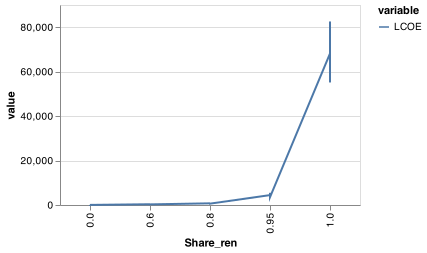

In [92]:
Totals_ren |>
     stack |>         #Stacking data
     @vlplot(width=300)+
     @vlplot(transform=[{filter="datum.variable == 'LCOE'"}],
            mark=:line, 
            x=:Share_ren, 
            y=:value,
            color=:variable) |> display

# Extension 1 (Storage technologies)


Storage technologies
The extension will include options for investing into strage technologies such as Li-ion batteries or convesion of electical energy into fuels such as H2 or Biomethanol. Furter on fossil fuels will be removed to estimate amount of storage required to achieve fully renewable electricity production by 2050. 

### Further model improvements

Ideas for further model improvements:
+ Green transition requirements (100% of electric energy from Renewables)
+ Backup generation requirements
+ Including price of fuel and CO2 tax
+ Energy import and export
+ Subsidy for renewables
+ Storage 
+ Sell/buy 
+ Electric cars
+ Heat

# Name of extension

## Formualtion
waht, why we do this
what are articles/resources that support the idea

## Mathematical model
constraint

## Implementation
coding
constraints, varaibles, data (parameters)

## Sensitivity analysis

###  Sub-conclusion
